In [11]:
#Preparação de dados e econometria clássica
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.statespace.structural import UnobservedComponents
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.ar_model import AutoReg

#Modelos de Mudança de Regime (Modelo de Regressão com Mudança de Regime de Markov):
    # em vez de um único modelo de regressão para explicar a série inteira, há vários modelos
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

#Modelagem Bayesiana:
    # parâmetros como variáveis aleatórias: tem uma distribuição de probabilidade, portanto com incerteza
    #resultado é uma distribuição de probabilidade
        #prior: crença sobre o parâmetro antes de ver os dados
        #likelihood: como os dados são gerados, função de verossimilhança
        #posterior: crença atualizada sobre o parâmetro após ver os dados
import pymc as pm
import arviz as az

#Visualização de dados
import plotly.graph_objects as go
import plotly.express as px
import plotly.colors 
import seaborn as sns
import warnings
from scipy.optimize import minimize
from pygam import LinearGAM, s, f
import plotly.graph_objects as go
import plotly.colors
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import os
import numpy as np

#Modelos Aditivos Generalizados (GAM)
    # Em vez de forçar uma relação linear, o GAM substitui esse termo por uma função suave e flexível
    #spline:divide o intervalo de $x$ em seções (definidas por "nós" ou knots) 
        # e ajusta funções mais simples (como pequenos polinômios cúbicos) em cada seção
from scipy.stats import norm

#Computação quântica: 
    #Uso de Otimização Combinatória: QAOA não é puramente quântico; ele é um algoritmo híbrido. 
        #Clássico 💻: O otimizador COBYLA (clássico) "chuta" um conjunto inicial de parâmetros (ângulos) para o circuito quântico.
        # Quântico ⚛️: O QAOAAnsatz (o circuito quântico) é montado com esses parâmetros. 
            # Ele é executado no processador quântico (ou simulador), usando superposição
            # e emaranhamento para explorar o vasto espaço de soluções do seu QuadraticProgram.
        # Quântico ⚛️: O circuito é medido, "colapsando" para uma solução candidata (ex: "rota A") e seu respectivo "custo".
        # Clássico 💻: O COBYLA recebe esse custo.
            # Ele então usa sua lógica clássica para decidir um novo conjunto de parâmetros para o circuito quântico, tentando obter um custo menor.


from qiskit import QuantumCircuit
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms import QAOA
from qiskit.circuit.library import TwoLocal, QAOAAnsatz
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer


# Usar o Sampler correto dependendo da versão
try:
    # Para Qiskit >= 1.0
    from qiskit.primitives import Sampler
    QISKIT_NEW = True
except ImportError:
    # Para versões antigas
    try:
        from qiskit_aer.primitives import Sampler
        QISKIT_NEW = False
    except ImportError:
        # Fallback: usar StatevectorSampler
        from qiskit.primitives import StatevectorSampler as Sampler
        QISKIT_NEW = True

from qiskit.quantum_info import SparsePauliOp

from tqdm import tqdm
import time

warnings.filterwarnings("ignore")

print(f"Usando PyMC versão: {pm.__version__}")
print(f"Modo Qiskit: {'Novo (>=1.0)' if QISKIT_NEW else 'Legacy'}")
print("="*80)
print("INICIANDO PIPELINE DE MODELOS")
print("="*80)

Usando PyMC versão: 5.26.1
Modo Qiskit: Novo (>=1.0)
INICIANDO PIPELINE DE MODELOS


In [2]:

# ===========================
# 1. SIMULAÇÃO DE DADOS (COM NOVOS VALORES DE REGIME)
# ===========================
np.random.seed(1872)
anos = np.arange(1872, 2023)
n_anos = len(anos)
pib_pc = 500 * np.exp(np.linspace(0, 1.5, n_anos)) + np.random.normal(0, 50, n_anos)
urbanizacao = 0.8 / (1 + np.exp(-0.05 * (anos - 1990))) + np.random.normal(0, 0.02, n_anos)
urbanizacao = np.clip(urbanizacao, 0.05, 0.85)
industrializacao = 0.6 / (1 + np.exp(-0.06 * (anos - 1980))) + np.random.normal(0, 0.02, n_anos)
educacao = 0.7 / (1 + np.exp(-0.04 * (anos - 1985))) + np.random.normal(0, 0.015, n_anos)

regimes_verdadeiros = np.zeros(n_anos, dtype=int)
gini_por_regime = {0: 0.40, 1: 0.43, 2: 0.46}
volatilidade_regime = {0: 0.025, 1: 0.015, 2: 0.020}
regime_atual = 0
for i in range(n_anos):
    ano_atual = anos[i]
    if ano_atual < 1930: regime_atual = 0
    elif 1930 <= ano_atual < 1960: regime_atual = 1
    elif 1960 <= ano_atual < 2000: regime_atual = 0
    else: regime_atual = 2
    regimes_verdadeiros[i] = regime_atual

tendencia = 0.6 - 0.10 * ((anos - 1872) / 150)
ciclica = -0.05 * np.sin(np.pi * (anos - 1872) / 40)
estrutural = 0.03 * np.cos(np.pi * (anos - 1872) / 25)
gini_regime = np.array([gini_por_regime[r] for r in regimes_verdadeiros])
noise_regime = np.array([np.random.normal(0, volatilidade_regime[r]) for r in regimes_verdadeiros])
gini_real = 0.1 * tendencia + 0.7 * gini_regime + 0.1 * ciclica + 0.1 * estrutural + noise_regime
gini_real = np.clip(gini_real, 0.35, 0.55)

df = pd.DataFrame({
    'Ano': anos, 'PIB_pc': pib_pc, 'Urbanizacao': urbanizacao,
    'Industrializacao': industrializacao, 'Educacao': educacao,
    'Gini_Verdadeiro': gini_real, 'Regime_Verdadeiro': regimes_verdadeiros
})

ano_inicio_pnad = 1976
# Criar Gini_Observado para seleção de lags 
df['Gini_Observado'] = np.nan
mask_moderno_inicial = df['Ano'] >= ano_inicio_pnad
df.loc[mask_moderno_inicial, 'Gini_Observado'] = df.loc[mask_moderno_inicial, 'Gini_Verdadeiro'] + \
                                                np.random.normal(0, 0.01, mask_moderno_inicial.sum())
n_total = len(df)

print("\nDADOS SIMULADOS (ainda sem Gini_Lag):")
print(f"Gini por Regime: {gini_por_regime}")
print("Primeiras linhas do DataFrame:")
print(df.head())
print("="*80)

# ===========================
# VISUALIZAÇÃO DOS DADOS
# ===========================
df_moderno_grafico = df[df['Ano'] >= ano_inicio_pnad].copy() 
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

# Gráfico 1: Gini e Regimes
fig, ax1 = plt.subplots(figsize=(16, 6))
sns.lineplot(data=df, x='Ano', y='Gini_Verdadeiro', label='Gini Verdadeiro (Latente)', ax=ax1, color='blue', linewidth=2.5)
sns.scatterplot(data=df_moderno_grafico, x='Ano', y='Gini_Observado', label=f'Gini Observado (pós-{ano_inicio_pnad})', ax=ax1, color='red', s=50, zorder=5)
ax1.set_title('Simulação do Índice Gini e Regimes Estruturais (1872-2022)', fontsize=16, pad=20)
ax1.set_ylabel('Índice Gini', fontsize=12, color='blue')
ax1.set_xlabel('Ano', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.fill_between(df['Ano'], df['Regime_Verdadeiro'], step='pre', alpha=0.2, color='gray', label='Regime (Eixo Direito)')
ax2.set_ylabel('Regime Estrutural', fontsize=12, color='gray')
ax2.tick_params(axis='y', labelcolor='gray', labelsize=9)
tick_locs = np.unique(regimes_verdadeiros)
ax2.set_yticks(tick_locs)
regime_nomes = [f"Regime {r} (Gini ~{gini_por_regime[r]})" for r in tick_locs]
ax2.set_yticklabels(regime_nomes)
ax2.grid(False)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')
plt.tight_layout()
plt.savefig("gini_regimes_plot.png")
plt.close(fig)
print("✓ Gráfico Gini vs Regimes salvo como gini_regimes_plot.png")

# Gráfico 2: Covariáveis
fig, axes = plt.subplots(4, 1, figsize=(16, 12), sharex=True)
fig.suptitle('Evolução das Covariáveis Simuladas (1872-2022)', fontsize=18, y=1.02)
sns.lineplot(data=df, x='Ano', y='PIB_pc', ax=axes[0], color='green'); axes[0].set_title('PIB per capita', fontsize=12); axes[0].set_ylabel('Valor')
sns.lineplot(data=df, x='Ano', y='Urbanizacao', ax=axes[1], color='orange'); axes[1].set_title('Taxa de Urbanização', fontsize=12); axes[1].set_ylabel('Taxa (0-1)')
sns.lineplot(data=df, x='Ano', y='Industrializacao', ax=axes[2], color='purple'); axes[2].set_title('Nível de Industrialização', fontsize=12); axes[2].set_ylabel('Nível (0-1)')
sns.lineplot(data=df, x='Ano', y='Educacao', ax=axes[3], color='brown'); axes[3].set_title('Nível de Educação', fontsize=12); axes[3].set_ylabel('Nível (0-1)')
axes[3].set_xlabel('Ano', fontsize=12)
plt.tight_layout()
plt.savefig("covariaveis_plot.png")
plt.close(fig)
print("✓ Gráfico Covariáveis salvo como covariaveis_plot.png")
print("="*80)

# --- SELEÇÃO DE LAGS PARA O GINI (BASEADO NO AIC) ---
print("\n[Seleção de Lags via AIC]")
print("→ Selecionando número de lags para Gini (max 10)...")
gini_moderno_observado = df.loc[mask_moderno_inicial, 'Gini_Observado'].dropna()

k_lags_selecionados = 1 # Valor padrão caso a seleção falhe

if len(gini_moderno_observado) > 10: # Checagem mínima de dados
    try:
        # Instanciar AutoReg para seleção de ordem
        # Passamos lags=None e ic='aic' para que ele escolha a melhor ordem até maxlag
        model_select = AutoReg(gini_moderno_observado, lags=None, trend='n', # trend='n' foca na autocorrelação
                                ic='aic', old_names=False) # old_names=False para compatibilidade
        results_select = model_select.fit(cov_type="nonrobust") # Ajusta para obter a seleção

        # Extrair os lags selecionados do resultado
        selected_lags = results_select.ar_lags
        k_lags_selecionados = max(selected_lags) if selected_lags is not None and len(selected_lags) > 0 else 1
        # Usamos o lag máximo encontrado, ou 1 se nenhum for selecionado

    except Exception as e:
        print(f"⚠ Erro na seleção automática de lags ({e}), usando k=1.")
        k_lags_selecionados = 1
else:
    print("⚠ Dados insuficientes para seleção automática, usando k=1.")
    k_lags_selecionados = 1

print(f"✓ Número de lags selecionados (k): {k_lags_selecionados}")

# --- CRIAÇÃO DAS COLUNAS DE LAG  ---
print("→ Criando colunas de lag no DataFrame principal...")
lag_cols_names = []
for i in range(1, k_lags_selecionados + 1):
    col_name = f'Gini_Lag_{i}'
    df[col_name] = df['Gini_Verdadeiro'].shift(i)
    # Preencher NaNs iniciais com o primeiro valor de Gini_Verdadeiro
    df[col_name].fillna(df['Gini_Verdadeiro'].iloc[0], inplace=True)
    lag_cols_names.append(col_name)
    print(f"  ✓ Coluna '{col_name}' criada e preenchida.")

# --- ATUALIZAR df_moderno e df_historico (permanece igual) ---
print("→ Atualizando DataFrames moderno e histórico...")
df_moderno = df[df['Ano'] >= ano_inicio_pnad].copy()
df_historico = df[df['Ano'] < ano_inicio_pnad].copy()
n_historico = len(df_historico)
n_moderno = len(df_moderno)
print(f"  ✓ df_moderno ({n_moderno} obs) e df_historico ({n_historico} obs) atualizados.")

print("\nPrimeiras linhas do DataFrame com colunas de lag:")
print(df.head())
print("="*80)

# --- LISTA DE PREDITORES BASE E DE LAGS (permanece igual) ---
predictors_base = ['PIB_pc', 'Urbanizacao', 'Industrializacao', 'Educacao']
predictors_lags = lag_cols_names
# --- FIM DAS LISTAS ---



DADOS SIMULADOS (ainda sem Gini_Lag):
Gini por Regime: {0: 0.4, 1: 0.43, 2: 0.46}
Primeiras linhas do DataFrame:
    Ano      PIB_pc  Urbanizacao  Industrializacao  Educacao  Gini_Verdadeiro  \
0  1872  417.208801         0.05         -0.008906  0.013242         0.350000   
1  1873  395.155205         0.05         -0.013185 -0.012422         0.350000   
2  1874  467.381449         0.05          0.036170 -0.002062         0.376359   
3  1875  519.945747         0.05          0.016229  0.011559         0.350000   
4  1876  559.001227         0.05          0.035544  0.002394         0.350000   

   Regime_Verdadeiro  Gini_Observado  
0                  0             NaN  
1                  0             NaN  
2                  0             NaN  
3                  0             NaN  
4                  0             NaN  
✓ Gráfico Gini vs Regimes salvo como gini_regimes_plot.png
✓ Gráfico Covariáveis salvo como covariaveis_plot.png

[Seleção de Lags via AIC]
→ Selecionando número de 

In [3]:
# ===========================
# 2. MODELO OLS BASELINE (com k lags)
# ===========================
print(f"\n[1/6] MODELO OLS (Baseline com k={k_lags_selecionados} Lags)")
predictors_ols = predictors_base + predictors_lags # Combina base + lags
print(f"→ Preditores OLS: {predictors_ols}")

with tqdm(total=100, desc="OLS", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}') as pbar:
    X_moderno_ols = df_moderno[predictors_ols]
    X_moderno_ols = sm.add_constant(X_moderno_ols)
    y_moderno_ols = df_moderno['Gini_Observado']
    pbar.update(30)

    modelo_ols = sm.OLS(y_moderno_ols, X_moderno_ols).fit()
    pbar.update(40)

    X_historico_ols = df_historico[predictors_ols]
    X_historico_ols = sm.add_constant(X_historico_ols)
    df_historico['Gini_OLS'] = modelo_ols.predict(X_historico_ols)
    pbar.update(30)

print(f"✓ R²: {modelo_ols.rsquared:.4f} | AIC: {modelo_ols.aic:.2f}")
print(modelo_ols.summary())
print("="*80)


[1/6] MODELO OLS (Baseline com k=1 Lags)
→ Preditores OLS: ['PIB_pc', 'Urbanizacao', 'Industrializacao', 'Educacao', 'Gini_Lag_1']


OLS: 100%|██████████| 100/100

✓ R²: 0.2597 | AIC: -226.71
                            OLS Regression Results                            
Dep. Variable:         Gini_Observado   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     2.876
Date:                Fri, 24 Oct 2025   Prob (F-statistic):             0.0257
Time:                        15:02:45   Log-Likelihood:                 119.36
No. Observations:                  47   AIC:                            -226.7
Df Residuals:                      41   BIC:                            -215.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const       

In [4]:

# ===========================
# 3. MARKOV SWITCHING REGRESSION (com k lags)
# ===========================
print(f"\n[2/6] MARKOV SWITCHING REGRESSION (com k={k_lags_selecionados} Lags)")
predictors_markov_base_subset = ['PIB_pc', 'Urbanizacao'] # Usando subconjunto base para Markov
predictors_markov = predictors_markov_base_subset + predictors_lags # Combina subconjunto base + lags
print(f"→ Preditores Markov: {predictors_markov}")

X_markov = df_moderno[predictors_markov].values
y_markov = df_moderno['Gini_Observado'].values
X_markov_const = sm.add_constant(X_markov)

# --- Atualizar número de preditores para Markov ---
num_predictors_markov = len(predictors_markov) + 1 # +1 para constante
print(f"  (Número total de coeficientes por regime: {num_predictors_markov})")
# --- Fim da atualização ---

try:
    with tqdm(total=100, desc="Markov", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}') as pbar:
        pbar.set_postfix_str("Inicializando modelo...")
        modelo_markov = MarkovRegression(
            endog=y_markov, k_regimes=2, exog=X_markov_const, switching_variance=True
        )
        pbar.update(20)

        pbar.set_postfix_str("Estimando (max 500 iter)...")
        resultado_markov = modelo_markov.fit(maxiter=500, disp=False)
        pbar.update(60)

        prob_regimes = resultado_markov.smoothed_marginal_probabilities
        regime_mais_provavel = np.argmax(prob_regimes, axis=1)
        pbar.update(10)

        # Backcasting
        X_hist_markov = df_historico[predictors_markov].values
        X_hist_markov_const = sm.add_constant(X_hist_markov)
        ultimo_regime = regime_mais_provavel[-1]

        # --- Ajustar índices dos parâmetros dinamicamente ---
        params = resultado_markov.params
        if ultimo_regime == 0:
             coefs_pred = params[:num_predictors_markov]
        else:
             coefs_pred = params[num_predictors_markov:(2 * num_predictors_markov)]
        # --- Fim do ajuste ---

        df_historico['Gini_Markov'] = X_hist_markov_const @ coefs_pred
        pbar.update(5)

        sigma_regime = np.sqrt(params[-(modelo_markov.k_regimes):])
        sigma_usado = sigma_regime[ultimo_regime]
        df_historico['Gini_Markov_Low'] = df_historico['Gini_Markov'] - 1.96 * sigma_usado
        df_historico['Gini_Markov_High'] = df_historico['Gini_Markov'] + 1.96 * sigma_usado
        pbar.update(5)

        df_moderno['Prob_Regime_0'] = prob_regimes[:, 0]
        df_moderno['Prob_Regime_1'] = prob_regimes[:, 1]
        df_moderno['Regime_Inferido'] = regime_mais_provavel

        markov_success = True

    print(f"✓ Convergência OK | AIC: {resultado_markov.aic:.2f}")
    print("\n" + "="*80)
    print("SUMÁRIO DO MODELO MARKOV SWITCHING (treinado nos dados modernos)")
    print("="*80)
    print(resultado_markov.summary())
    print("="*80)

except Exception as e:
    print(f"⚠ Falhou: {e}")
    print("→ Usando K-means como fallback...")

    # K-means e OLS por cluster
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    kmeans_data = np.column_stack([y_markov, X_markov])
    regime_mais_provavel = kmeans.fit_predict(kmeans_data)

    coefs_regimes = []
    for r in range(2):
        mask = regime_mais_provavel == r
        X_r = X_markov_const[mask]
        y_r = y_markov[mask]
        coefs_r = np.linalg.lstsq(X_r, y_r, rcond=None)[0]
        coefs_regimes.append(coefs_r)

    ultimo_regime = regime_mais_provavel[-1]
    X_hist_markov_const = sm.add_constant(df_historico[predictors_markov].values)
    df_historico['Gini_Markov'] = X_hist_markov_const @ coefs_regimes[ultimo_regime]
    df_historico['Gini_Markov_Low'] = df_historico['Gini_Markov'] - 0.03 # Intervalo fixo
    df_historico['Gini_Markov_High'] = df_historico['Gini_Markov'] + 0.03 # Intervalo fixo
    df_moderno['Regime_Inferido'] = regime_mais_provavel
    markov_success = False

    print("\n" + "="*80)
    print("SUMÁRIO DO FALLBACK (K-Means + OLS por cluster)")
    print("="*80)
    print(f"Clusters (regimes) encontrados: {len(coefs_regimes)}")
    print(f"Variáveis usadas no OLS: ['const'] + {predictors_markov}")
    for r, coefs in enumerate(coefs_regimes):
        print(f"\n--- Coeficientes para Regime (Cluster) {r} ---")
        print(f"  const: {coefs[0]:.6f}")
        for i, pred_name in enumerate(predictors_markov):
             print(f"  {pred_name}: {coefs[i+1]:.6f}")

    print(f"\nÚltimo regime observado: {ultimo_regime}")
    print(f"→ Coeficientes do Regime {ultimo_regime} serão usados para o backcasting.")
    print("="*80)


[2/6] MARKOV SWITCHING REGRESSION (com k=1 Lags)
→ Preditores Markov: ['PIB_pc', 'Urbanizacao', 'Gini_Lag_1']
  (Número total de coeficientes por regime: 4)


Markov:  20%|██        | 20/100

⚠ Falhou: Steady-state probabilities could not be constructed.
→ Usando K-means como fallback...



SUMÁRIO DO FALLBACK (K-Means + OLS por cluster)
Clusters (regimes) encontrados: 2
Variáveis usadas no OLS: ['const'] + ['PIB_pc', 'Urbanizacao', 'Gini_Lag_1']

--- Coeficientes para Regime (Cluster) 0 ---
  const: 0.382153
  PIB_pc: -0.000148
  Urbanizacao: 0.335148
  Gini_Lag_1: 0.238504

--- Coeficientes para Regime (Cluster) 1 ---
  const: 0.176603
  PIB_pc: 0.000103
  Urbanizacao: -0.207605
  Gini_Lag_1: 0.297377

Último regime observado: 1
→ Coeficientes do Regime 1 serão usados para o backcasting.


In [5]:
# ===========================
# 4. GENERALIZED ADDITIVE MODELS (GAMs) (com k lags)
# ===========================
print(f"\n[3/6] GENERALIZED ADDITIVE MODELS (GAMs com k={k_lags_selecionados} Lags)")
predictors_gam = predictors_base + predictors_lags # Combina base + lags
print(f"→ Preditores GAM: {predictors_gam}")

X_gam_treino = df_moderno[predictors_gam].values
y_gam_treino = df_moderno['Gini_Observado'].values

# --- Ajustar n_splines_list e gam_terms dinamicamente ---
n_splines_base = [8, 6, 6, 6]
n_splines_lags = [6] * k_lags_selecionados
n_splines_list = n_splines_base + n_splines_lags
print(f"  (Número de splines por preditor: {n_splines_list})")

gam_terms = None
num_total_predictors_gam = len(predictors_gam)
for i in range(num_total_predictors_gam):
    term = s(i, n_splines=n_splines_list[i])
    if gam_terms is None:
        gam_terms = term
    else:
        gam_terms += term
# --- Fim do ajuste ---


with tqdm(total=100, desc="GAM", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}') as pbar:
    pbar.set_postfix_str("Grid search...")
    gam_model = LinearGAM(gam_terms)

    gam_model.gridsearch(X_gam_treino, y_gam_treino)
    pbar.update(70)

    X_gam_historico = df_historico[predictors_gam].values
    df_historico['Gini_GAM'] = gam_model.predict(X_gam_historico)
    pbar.update(20)

    gam_intervals = gam_model.prediction_intervals(X_gam_historico, width=0.95)
    df_historico['Gini_GAM_Low'] = gam_intervals[:, 0]
    df_historico['Gini_GAM_High'] = gam_intervals[:, 1]
    pbar.update(10)

print(f"✓ Pseudo R²: {gam_model.statistics_['pseudo_r2']['explained_deviance']:.4f}")
print("\n" + "="*80)
print("SUMÁRIO DO MODELO GAM (treinado nos dados modernos)")
print("="*80)
print(gam_model.summary())
print("="*80)


[3/6] GENERALIZED ADDITIVE MODELS (GAMs com k=1 Lags)
→ Preditores GAM: ['PIB_pc', 'Urbanizacao', 'Industrializacao', 'Educacao', 'Gini_Lag_1']
  (Número de splines por preditor: [8, 6, 6, 6, 6])


GAM:   0%|          | 0/100  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 27% (3 of 11) |######                   | Elapsed Time: 0:00:00 ETA:   0:00:00
 72% (8 of 11) |##################       | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
GAM: 100%|██████████| 100/100

✓ Pseudo R²: 0.5812

SUMÁRIO DO MODELO GAM (treinado nos dados modernos)
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     11.9334
Link Function:                     IdentityLink Log Likelihood:                                -63094.0804
Number of Samples:                           47 AIC:                                           126214.0277
                                                AICc:                                          126224.9273
                                                GCV:                                                0.0005
                                                Scale:                                              0.0003
                                                Pseudo R-Squared:      

In [6]:
# ===========================
# 5. SÉRIE TEMPORAL ESTRUTURAL (UCM - Sem alterações)
# ===========================
print("\n[4/6] MODELO DE SÉRIE TEMPORAL ESTRUTURAL (UCM)")
ts_data = df_moderno.set_index('Ano')['Gini_Observado']

with tqdm(total=100, desc="TimeSeries", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}') as pbar:
    pbar.set_postfix_str("Modelo forward...")
    modelo_uc = UnobservedComponents(
        ts_data, level='local linear trend', cycle=True,
        stochastic_cycle=True, damped_cycle=True, irregular=True
    )
    resultado_uc = modelo_uc.fit(disp=False)
    pbar.update(40)

    pbar.set_postfix_str("Modelo backward...")
    ts_invertida = ts_data[::-1]
    modelo_uc_inv = UnobservedComponents(
        ts_invertida, level='local linear trend', cycle=True,
        stochastic_cycle=True, damped_cycle=True, irregular=True
    )
    resultado_uc_inv = modelo_uc_inv.fit(disp=False)
    pbar.update(40)

    pbar.set_postfix_str("Backcasting...")
    forecast_inv = resultado_uc_inv.forecast(steps=n_historico)
    df_historico['Gini_TimeSeries'] = forecast_inv[::-1].values
    forecast_summary = resultado_uc_inv.get_forecast(steps=n_historico).summary_frame(alpha=0.05)
    df_historico['Gini_TS_Low'] = forecast_summary['mean_ci_lower'][::-1].values
    df_historico['Gini_TS_High'] = forecast_summary['mean_ci_upper'][::-1].values
    pbar.update(20)

print(f"✓ AIC (modelo forward): {resultado_uc.aic:.2f}")
print("\n" + "="*80)
print("SUMÁRIO DO MODELO UCM (treinado nos dados modernos - forward)")
print("="*80)
print(resultado_uc.summary())
print("="*80)


[4/6] MODELO DE SÉRIE TEMPORAL ESTRUTURAL (UCM)


TimeSeries: 100%|██████████| 100/100

✓ AIC (modelo forward): -165.66

SUMÁRIO DO MODELO UCM (treinado nos dados modernos - forward)
                            Unobserved Components Results                            
Dep. Variable:                Gini_Observado   No. Observations:                   47
Model:                    local linear trend   Log Likelihood                  88.832
                   + damped stochastic cycle   AIC                           -165.663
Date:                       Fri, 24 Oct 2025   BIC                           -155.096
Time:                               15:03:20   HQIC                          -161.766
Sample:                                    0                                         
                                        - 47                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------

In [7]:
# ===========================
# 6. MODELO BAYESIANO HIERÁRQUICO (com k lags)
# ===========================
print(f"\n[5/6] MODELO BAYESIANO HIERÁRQUICO (OTIMIZADO com k={k_lags_selecionados} Lags)")

if df_moderno.empty or len(df_moderno) < 10:
    print("⚠ Dados insuficientes para modelo Bayesiano. Pulando...")
    df_historico['Gini_Bayes_Hierarquico'] = np.nan
    df_historico['Gini_Bayes_Low'] = np.nan
    df_historico['Gini_Bayes_High'] = np.nan
else:
    # --- Atualizar colunas para normalização e coords ---
    print(f"→ Normalizando preditores (incluindo {k_lags_selecionados} lags)...")
    scaler_bayes = StandardScaler()
    cols_norm_bayes = predictors_base + predictors_lags # Usa k lags
    norm_cols_names_bayes = [col + '_norm' for col in predictors_base] + \
                            [col + '_norm' for col in predictors_lags] # Nomes normalizados
    print(f"  (Colunas normalizadas: {norm_cols_names_bayes})")

    df[norm_cols_names_bayes] = scaler_bayes.fit_transform(df[cols_norm_bayes])

    mask_historico = df['Ano'] < ano_inicio_pnad
    mask_moderno = df['Ano'] >= ano_inicio_pnad
    historico_idx = np.where(mask_historico)[0]
    moderno_idx = np.where(mask_moderno)[0]

    coords = {"preditores": norm_cols_names_bayes} # Atualizado coords
    X_data_total = df[coords["preditores"]].values
    # --- Fim da atualização ---

    gini_col = 'Gini_Observado'
    if gini_col not in df_moderno.columns:
         gini_col = 'Gini_Verdadeiro'; print(f"→ Usando coluna: '{gini_col}'")

    try:
        y_observado = df_moderno[gini_col].dropna().values
        print(f"→ Usando {len(y_observado)} observações de df_moderno['{gini_col}']")
    except Exception as e:
        print(f"✗ Erro ao extrair y_observado: {e}"); raise

    n_total = len(df)
    bayesian_run_success = False
    trace_avancado = None

    with pm.Model(coords=coords) as modelo_bayes_avancado:
        alpha = pm.Normal('alpha', mu=0.55, sigma=0.1)
        # --- O modelo adapta-se automaticamente aos preditores via dims ---
        betas = pm.Normal('betas', mu=0, sigma=0.3, dims="preditores")
        # --- Fim da adaptação ---

        sigma_temporal = pm.HalfNormal('sigma_temporal', sigma=0.01)
        tendencia_passos = pm.Normal('tendencia_passos', mu=0, sigma=sigma_temporal, shape=n_total)
        tendencia = pm.Deterministic('tendencia', pm.math.cumsum(tendencia_passos))

        sigma = pm.HalfNormal('sigma', sigma=0.02)
        mu = alpha + pm.math.dot(X_data_total, betas) + tendencia # Usa X_data_total com k lags norm

        y_obs = pm.Normal('y_obs', mu=mu[moderno_idx], sigma=sigma, observed=y_observado)
        mu_hist = pm.Deterministic('mu_hist', mu[historico_idx])

        print("→ Amostragem MCMC: 4 chains × 3000 iterações")
        print("  (target_accept=0.95)")
        samplers_config = [("blackjax", {"sampler": "blackjax"}), ("nuts", {})]

        for sampler_name, sampler_kwargs in samplers_config:
            try:
                trace_avancado = pm.sample(draws=1500, tune=1500, chains=4, target_accept=0.95, progressbar=True, return_inferencedata=True, **sampler_kwargs)
                print(f"✓ {sampler_name.upper()} usado com sucesso")
                bayesian_run_success = True
                break
            except Exception as e:
                print(f"⚠ {sampler_name.upper()} falhou: {str(e)[:100]}")
                if sampler_name == samplers_config[-1][0]: print("✗ Todos os samplers falharam")
                else: print("→ Tentando próximo sampler...")

    if bayesian_run_success and trace_avancado is not None:
        print("\n" + "="*70); print("DIAGNÓSTICOS DO MODELO"); print("="*70)
        try:
            rhat = az.rhat(trace_avancado, var_names=["alpha", "betas"])
            ess = az.ess(trace_avancado, var_names=["alpha", "betas"])
            print(f"R-hat máximo: {rhat.max().values:.4f} (ideal < 1.01)")
            print(f"ESS mínimo: {ess.min().values:.0f} (ideal > 400)")
            summary_bayes = az.summary(trace_avancado, var_names=["alpha", "betas", "sigma_temporal", "sigma"], stat_focus="median")
            print("\nPARÂMETROS PRINCIPAIS:"); print(summary_bayes[['mean', 'sd', 'hdi_3%', 'hdi_97%', 'r_hat']])
        except Exception as e: print(f"⚠ Erro nos diagnósticos: {e}")
        print("="*70)

        try:
            print("\n→ Extraindo predições posteriores...")
            posterior_pred = trace_avancado.posterior['mu_hist']
            df_historico['Gini_Bayes_Hierarquico'] = posterior_pred.mean(dim=['chain', 'draw']).values
            hdi = az.hdi(posterior_pred, hdi_prob=0.95)
            df_historico['Gini_Bayes_Low'] = hdi['mu_hist'].sel(hdi='lower').values
            df_historico['Gini_Bayes_High'] = hdi['mu_hist'].sel(hdi='higher').values
            print(f"✓ Predições extraídas ({len(df_historico)} anos)")
        except KeyError as e:
            print(f"⚠ Variável não encontrada no trace: {e} → Usando fallback (NaN)"); df_historico[['Gini_Bayes_Hierarquico', 'Gini_Bayes_Low', 'Gini_Bayes_High']] = np.nan
        except Exception as e:
            print(f"⚠ Erro inesperado na extração: {e}"); df_historico[['Gini_Bayes_Hierarquico', 'Gini_Bayes_Low', 'Gini_Bayes_High']] = np.nan
    else:
        print("\n⚠ Amostragem MCMC falhou completamente → Série Bayesiana não disponível"); df_historico[['Gini_Bayes_Hierarquico', 'Gini_Bayes_Low', 'Gini_Bayes_High']] = np.nan

print("\n✓ Etapa Bayesiana concluída")
print("="*80)


[5/6] MODELO BAYESIANO HIERÁRQUICO (OTIMIZADO com k=1 Lags)
→ Normalizando preditores (incluindo 1 lags)...
  (Colunas normalizadas: ['PIB_pc_norm', 'Urbanizacao_norm', 'Industrializacao_norm', 'Educacao_norm', 'Gini_Lag_1_norm'])
→ Usando 47 observações de df_moderno['Gini_Observado']
→ Amostragem MCMC: 4 chains × 3000 iterações
  (target_accept=0.95)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, betas, sigma_temporal, tendencia_passos, sigma]


Sampling 4 chains for 1_500 tune and 1_500 draw iterations (6_000 + 6_000 draws total) took 66 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


✓ BLACKJAX usado com sucesso

DIAGNÓSTICOS DO MODELO
⚠ Erro nos diagnósticos: unsupported format string passed to method.__format__

→ Extraindo predições posteriores...
✓ Predições extraídas (104 anos)

✓ Etapa Bayesiana concluída


In [8]:
# ===========================
# 7. COMPUTAÇÃO QUÂNTICA (QAOA) - VERSÃO RÁPIDA (com k lags)
# ===========================
print(f"\n[6/6] COMPUTAÇÃO QUÂNTICA: QAOA (com k={k_lags_selecionados} Lags)")

# --- Atualizar preditores e número de variáveis/qubits ---
predictors_qaoa = predictors_base + predictors_lags # Combina base + k lags
print(f"→ Preditores QAOA: {predictors_qaoa}")
n_vars = len(predictors_qaoa) # Número de variáveis (4 base + k lags)
n_bits = 2 # Mantido 2 bits por variável
n_qubits = n_vars * n_bits
print(f"⚠ Versão otimizada: {n_qubits} qubits ({n_vars} vars × {n_bits} bits/var), 30 iterações")
# --- Fim da atualização ---


X_quantum = df_moderno[predictors_qaoa].values
y_quantum = df_moderno['Gini_Observado'].values

# Normalização
X_min = X_quantum.min(axis=0); X_max = X_quantum.max(axis=0)
y_min = y_quantum.min(); y_max = y_quantum.max()
X_quantum_norm = 2 * (X_quantum - X_min) / (X_max - X_min) - 1
y_quantum_norm = 2 * (y_quantum - y_min) / (y_max - y_min) - 1

n_samples = 5 # Mantido baixo
X_q = X_quantum_norm[:n_samples]; y_q = y_quantum_norm[:n_samples]
XtX = X_q.T @ X_q; Xty = X_q.T @ y_q

qp = QuadraticProgram()

with tqdm(total=100, desc="QAOA", bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}') as pbar:
    pbar.set_postfix_str("Montando problema...")
    # --- Loops atualizados para n_vars ---
    for i in range(n_vars):
        for j in range(n_bits):
            qp.binary_var(f'beta_{i}_{j}')

    linear = {}; quadratic = {}
    for i in range(n_vars):
        for b in range(n_bits):
            var_name = f'beta_{i}_{b}'; weight = 2 ** b
            linear[var_name] = -2 * Xty[i] * weight
            for j in range(n_vars):
                for b2 in range(n_bits):
                    var_name2 = f'beta_{j}_{b2}'; weight2 = 2 ** b2
                    if var_name <= var_name2:
                        quadratic[(var_name, var_name2)] = XtX[i, j] * weight * weight2
    # --- Fim da atualização ---

    qp.minimize(linear=linear, quadratic=quadratic)
    pbar.update(20)

    try:
        pbar.set_postfix_str("Inicializando sampler...")
        sampler = Sampler()
        qaoa = QAOA(sampler=sampler, optimizer=COBYLA(maxiter=30), reps=2)
        optimizer = MinimumEigenOptimizer(qaoa)
        pbar.update(10)

        pbar.set_postfix_str("Otimizando (30 iter)...")
        start_time = time.time()
        resultado_qaoa = optimizer.solve(qp)
        elapsed = time.time() - start_time
        pbar.update(60)

        # --- Reconstrução e Previsão atualizadas para n_vars ---
        coefs_quanticos = np.zeros(n_vars)
        for i in range(n_vars):
            for b in range(n_bits):
                var_name = f'beta_{i}_{b}'
                if var_name in resultado_qaoa.variables_dict:
                    coefs_quanticos[i] += resultado_qaoa.variables_dict[var_name] * (2 ** b)

        coefs_quanticos_norm = coefs_quanticos / (2 ** n_bits)
        coefs_quanticos_final = coefs_quanticos_norm * 0.2 - 0.1 # Heurística

        X_hist_qaoa = df_historico[predictors_qaoa].values # Usa df_historico com k lags
        X_hist_norm = 2 * (X_hist_qaoa - X_min) / (X_max - X_min) - 1
        pred_quantum_norm = X_hist_norm @ coefs_quanticos_final
        df_historico['Gini_Quantum'] = (pred_quantum_norm + 1) / 2 * (y_max - y_min) + y_min
        # --- Fim da atualização ---
        pbar.update(10)

        quantum_success = True
        print(f"✓ Concluído em {elapsed:.1f}s")

        print("\n" + "="*80)
        print(f"SUMÁRIO DO MODELO QUÂNTICO (QAOA com k={k_lags_selecionados} Lags)")
        print("="*80)
        print("--- Resultado Bruto (Bits Ótimos) ---")
        print(resultado_qaoa)
        print("\n--- Coeficientes Finais Reconstruídos ---")
        print(f" (Valores de {n_bits} bits antes da normalização: {coefs_quanticos})")
        print(f" (Valores normalizados [0,1]: {coefs_quanticos_norm})")
        print("\nCoeficientes Finais (usados na previsão):")
        for i, name in enumerate(predictors_qaoa): # Usa predictors_qaoa atualizado
            print(f"  beta_{name}: {coefs_quanticos_final[i]:.6f}")
        print("="*80)

    except Exception as e:
        print(f"⚠ Falhou: {e}")
        print("→ Usando fallback OLS")
        df_historico['Gini_Quantum'] = df_historico['Gini_OLS']
        quantum_success = False


print("\n================================================================================")
print("✓ PIPELINE COMPLETO")
print("================================================================================")



[6/6] COMPUTAÇÃO QUÂNTICA: QAOA (com k=1 Lags)
→ Preditores QAOA: ['PIB_pc', 'Urbanizacao', 'Industrializacao', 'Educacao', 'Gini_Lag_1']
⚠ Versão otimizada: 10 qubits (5 vars × 2 bits/var), 30 iterações


QAOA: 100%|██████████| 100/100

✓ Concluído em 855.5s

SUMÁRIO DO MODELO QUÂNTICO (QAOA com k=1 Lags)
--- Resultado Bruto (Bits Ótimos) ---
fval=0.0, beta_0_0=0.0, beta_0_1=0.0, beta_1_0=0.0, beta_1_1=0.0, beta_2_0=0.0, beta_2_1=0.0, beta_3_0=0.0, beta_3_1=0.0, beta_4_0=0.0, beta_4_1=0.0, status=SUCCESS

--- Coeficientes Finais Reconstruídos ---
 (Valores de 2 bits antes da normalização: [0. 0. 0. 0. 0.])
 (Valores normalizados [0,1]: [0. 0. 0. 0. 0.])

Coeficientes Finais (usados na previsão):
  beta_PIB_pc: -0.100000
  beta_Urbanizacao: -0.100000
  beta_Industrializacao: -0.100000
  beta_Educacao: -0.100000
  beta_Gini_Lag_1: -0.100000

✓ PIPELINE COMPLETO


In [9]:

# ===========================
# 8. MÉTRICAS DE AVALIAÇÃO (Atualizado Labels)
# ===========================
print("\n" + "="*80)
print(f"MÉTRICAS DE AVALIAÇÃO (vs Gini_Verdadeiro no período histórico, k={k_lags_selecionados} lags)")
print("="*80)

modelos_avaliados = {
    f'OLS (k={k_lags_selecionados} Lags)': 'Gini_OLS',
    f'Markov (k={k_lags_selecionados} Lags)': 'Gini_Markov',
    f'GAM (k={k_lags_selecionados} Lags)': 'Gini_GAM',
    'Série Temporal (UCM)': 'Gini_TimeSeries', # Sem lags exógenos
    f'Bayesiano (k={k_lags_selecionados} Lags)': 'Gini_Bayes_Hierarquico',
    f'Quantum (k={k_lags_selecionados} Lags)': 'Gini_Quantum'
}

resultados = []
y_verdadeiro_hist = df_historico['Gini_Verdadeiro']

for nome, coluna in modelos_avaliados.items():
    if coluna in df_historico.columns and not df_historico[coluna].isnull().all():
        y_pred_hist = df_historico[coluna]
        mae = mean_absolute_error(y_verdadeiro_hist, y_pred_hist)
        rmse = np.sqrt(mean_squared_error(y_verdadeiro_hist, y_pred_hist))
        r2 = r2_score(y_verdadeiro_hist, y_pred_hist)
        resultados.append({'Modelo': nome, 'MAE': mae, 'RMSE': rmse, 'R²': r2})
        print(f"{nome:30s} | MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")
    else:
        print(f"{nome:30s} | Coluna não encontrada ou vazia. Pulando métricas.")
        resultados.append({'Modelo': nome, 'MAE': np.nan, 'RMSE': np.nan, 'R²': np.nan})


df_resultados = pd.DataFrame(resultados)
# Atualizar cores/nomes se necessário para consistência
cores = {f'OLS (k={k_lags_selecionados} Lags)': '#FF6B6B', f'Markov (k={k_lags_selecionados} Lags)': '#F4A261',
         f'GAM (k={k_lags_selecionados} Lags)': '#4ECDC4', 'Série Temporal (UCM)': '#FFE66D',
         f'Bayesiano (k={k_lags_selecionados} Lags)': '#95E1D3', f'Quantum (k={k_lags_selecionados} Lags)': '#9D4EDD'}




MÉTRICAS DE AVALIAÇÃO (vs Gini_Verdadeiro no período histórico, k=1 lags)
OLS (k=1 Lags)                 | MAE: 0.0348 | RMSE: 0.0372 | R²: -13.2176
Markov (k=1 Lags)              | MAE: 0.0169 | RMSE: 0.0205 | R²: -3.3292
GAM (k=1 Lags)                 | MAE: 0.0325 | RMSE: 0.0370 | R²: -13.1094
Série Temporal (UCM)           | MAE: 0.2947 | RMSE: 0.3374 | R²: -1171.3369
Bayesiano (k=1 Lags)           | MAE: 0.0224 | RMSE: 0.0274 | R²: -6.7334
Quantum (k=1 Lags)             | MAE: 0.0694 | RMSE: 0.0708 | R²: -50.6513



CONFIGURANDO DIRETÓRIO DE SAÍDA (WSL)
Diretório de saída (WSL): /mnt/c/Users/daves/OneDrive/Pessoal/Acadêmico/Doutorado/Codes
Existe: True
✓ Diretório é gravável

GERANDO GRÁFICO INTERATIVO PLOTLY

Salvando Plotly em: /mnt/c/Users/daves/OneDrive/Pessoal/Acadêmico/Doutorado/Codes/grafico_backcasting_interativo_k1lags.html
✓ SUCESSO! Gráfico Plotly salvo
  → Arquivo: grafico_backcasting_interativo_k1lags.html
  → Tamanho: 4755.0 KB
  → Caminho absoluto: /mnt/c/Users/daves/OneDrive/Pessoal/Acadêmico/Doutorado/Codes/grafico_backcasting_interativo_k1lags.html
  → Caminho Windows: C:\Users\daves\OneDrive\Pessoal\Acadêmico\Doutorado\Codes\grafico_backcasting_interativo_k1lags.html



GERANDO GRÁFICO ESTÁTICO MATPLOTLIB

Salvando Matplotlib em: /mnt/c/Users/daves/OneDrive/Pessoal/Acadêmico/Doutorado/Codes/grafico_backcasting_estatico_k1lags.jpg
✓ SUCESSO! Gráfico Matplotlib salvo
  → Arquivo: grafico_backcasting_estatico_k1lags.jpg
  → Tamanho: 470.3 KB
  → Caminho absoluto: /mnt/c/Users/daves/OneDrive/Pessoal/Acadêmico/Doutorado/Codes/grafico_backcasting_estatico_k1lags.jpg
  → Caminho Windows: C:\Users\daves\OneDrive\Pessoal\Acadêmico\Doutorado\Codes\grafico_backcasting_estatico_k1lags.jpg


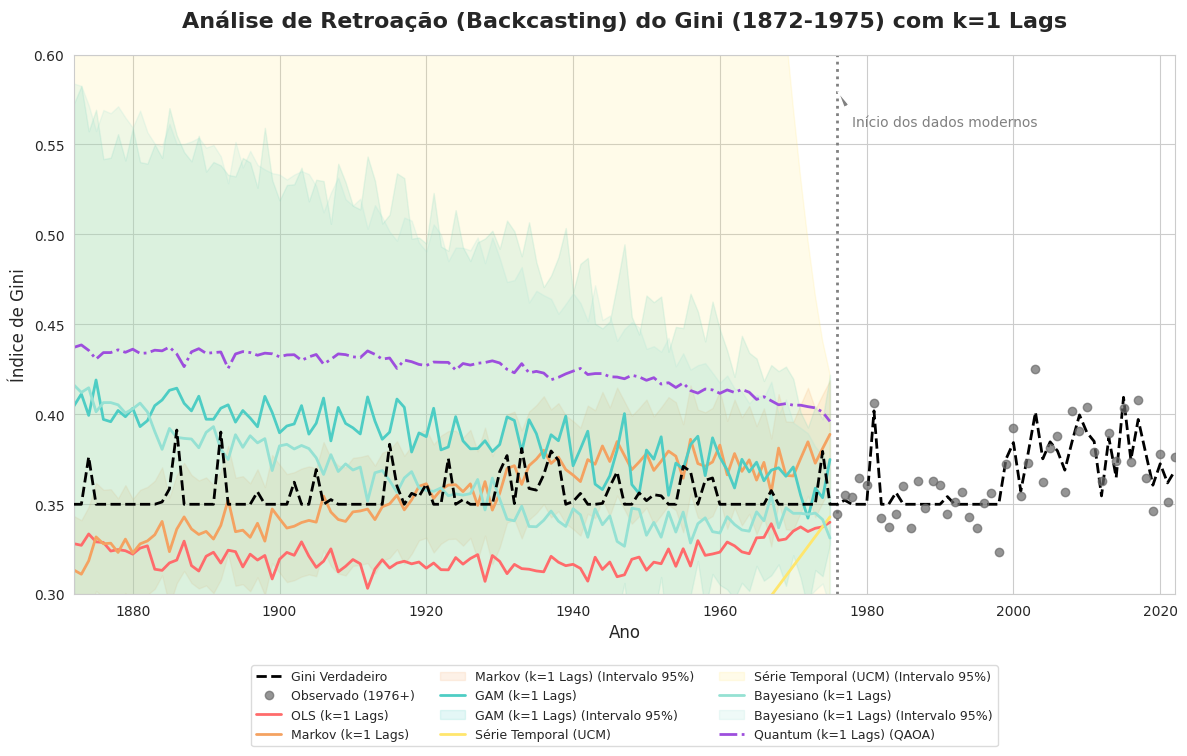


RESUMO DOS ARQUIVOS GERADOS
Diretório: /mnt/c/Users/daves/OneDrive/Pessoal/Acadêmico/Doutorado/Codes

Arquivos:
  1. grafico_backcasting_interativo_k1lags.html
     Existe: True
     Tamanho: 4755.0 KB

  2. grafico_backcasting_estatico_k1lags.jpg
     Existe: True
     Tamanho: 470.3 KB

✓ VISUALIZAÇÃO CONCLUÍDA


In [22]:
# ===========================
# 9. VISUALIZAÇÃO - VERSÃO WSL
# ===========================
import plotly.graph_objects as go
import plotly.colors
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import os
from pathlib import Path
import numpy as np

# --- Labels Atualizados ---
ols_label = f'OLS (k={k_lags_selecionados} Lags)'
markov_label = f'Markov (k={k_lags_selecionados} Lags)'
gam_label = f'GAM (k={k_lags_selecionados} Lags)'
bayes_label = f'Bayesiano (k={k_lags_selecionados} Lags)'
quantum_base_label = f'Quantum (k={k_lags_selecionados} Lags)'
ts_label = 'Série Temporal (UCM)'

# --- Cores ---
if 'cores' not in locals() or not all(k in cores for k in [ols_label, markov_label, gam_label, ts_label, bayes_label, quantum_base_label]):
     cores = {
         ols_label: '#FF6B6B', markov_label: '#F4A261', gam_label: '#4ECDC4',
         ts_label: '#FFE66D', bayes_label: '#95E1D3', quantum_base_label: '#9D4EDD'
     }
     print("Aviso: Dicionário 'cores' redefinido.")

# ====================================================================
# CONFIGURAÇÃO DE DIRETÓRIO - WSL
# ====================================================================

print("\n" + "="*70)
print("CONFIGURANDO DIRETÓRIO DE SAÍDA (WSL)")
print("="*70)

# Converter caminho Windows para WSL
# C:\Users\daves\OneDrive\... -> /mnt/c/Users/daves/OneDrive/...
output_dir = Path('/mnt/c/Users/daves/OneDrive/Pessoal/Acadêmico/Doutorado/Codes')

print(f"Diretório de saída (WSL): {output_dir}")
print(f"Existe: {output_dir.exists()}")

# Verificar se é gravável
if output_dir.exists():
    try:
        test_file = output_dir / "test_write.tmp"
        test_file.touch()
        test_file.unlink()
        print(f"✓ Diretório é gravável")
    except Exception as e:
        print(f"⚠ Erro ao testar escrita: {e}")
        output_dir = Path.cwd()
        print(f"→ Usando diretório atual: {output_dir}")
else:
    print(f"⚠ Diretório não existe!")
    output_dir = Path.cwd()
    print(f"→ Usando diretório atual: {output_dir}")

# ====================================================================
# 9.a GRÁFICO INTERATIVO PLOTLY
# ====================================================================

print("\n" + "="*70)
print("GERANDO GRÁFICO INTERATIVO PLOTLY")
print("="*70)

fig_plotly = go.Figure()

# Gini Verdadeiro e Observado
fig_plotly.add_trace(go.Scatter(
    x=df['Ano'], y=df['Gini_Verdadeiro'], 
    mode='lines', name='Gini Verdadeiro', 
    line=dict(color='black', width=2.5, dash='dash'), 
    hoverinfo='name+x+y', legendgroup='Gini'
))

fig_plotly.add_trace(go.Scatter(
    x=df_moderno['Ano'], y=df_moderno['Gini_Observado'], 
    mode='markers', name='Observado (1976+)', 
    marker=dict(color='dimgray', size=8, opacity=0.7), 
    hoverinfo='name+x+y', legendgroup='Gini'
))

fig_plotly.add_vline(
    x=ano_inicio_pnad, line_dash="dot", line_color="gray", 
    line_width=2, annotation_text="Início dos dados modernos", 
    annotation_position="top left"
)

# --- Funções auxiliares Plotly ---
def add_model_trace(fig, df_hist, col_name, color, line_style, label, legend_group, show_legend=True):
    if col_name in df_hist.columns and not df_hist[col_name].isnull().all():
        fig.add_trace(go.Scatter(
            x=df_hist['Ano'], y=df_hist[col_name],
            mode='lines', name=label, 
            line=dict(color=color, width=2.5, dash=line_style),
            hoverinfo='name+x+y', legendgroup=legend_group, 
            showlegend=show_legend
        ))

def add_fill_trace(fig, df_hist, low_col, high_col, color, model_name, legend_group):
    if low_col in df_hist.columns and high_col in df_hist.columns and \
       not df_hist[low_col].isnull().all() and not df_hist[high_col].isnull().all():
        fig.add_trace(go.Scatter(
            x=df_hist['Ano'], y=df_hist[high_col], 
            mode='lines', line=dict(width=0),
            showlegend=False, hoverinfo='skip', 
            legendgroup=legend_group
        ))
        rgb = plotly.colors.hex_to_rgb(color)
        rgba_color = f'rgba({rgb[0]}, {rgb[1]}, {rgb[2]}, 0.15)'
        fig.add_trace(go.Scatter(
            x=df_hist['Ano'], y=df_hist[low_col], 
            mode='lines', line=dict(width=0),
            fill='tonexty', fillcolor=rgba_color, 
            name=f'{model_name} (Intervalo 95%)',
            hoverinfo='name+x', legendgroup=legend_group
        ))

# Adicionar modelos
add_model_trace(fig_plotly, df_historico, 'Gini_OLS', cores[ols_label], 'solid', ols_label, 'OLS', True)

add_model_trace(fig_plotly, df_historico, 'Gini_Markov', cores[markov_label], 'solid', markov_label, 'Markov', True)
if ('Gini_Markov_Low' in df_historico.columns and 'Gini_Markov_High' in df_historico.columns):
    add_fill_trace(fig_plotly, df_historico, 'Gini_Markov_Low', 'Gini_Markov_High', cores[markov_label], markov_label, 'Markov')

add_model_trace(fig_plotly, df_historico, 'Gini_GAM', cores[gam_label], 'solid', gam_label, 'GAM', True)
if ('Gini_GAM_Low' in df_historico.columns and 'Gini_GAM_High' in df_historico.columns):
    add_fill_trace(fig_plotly, df_historico, 'Gini_GAM_Low', 'Gini_GAM_High', cores[gam_label], gam_label, 'GAM')

add_model_trace(fig_plotly, df_historico, 'Gini_TimeSeries', cores[ts_label], 'solid', ts_label, 'TS', True)
if ('Gini_TS_Low' in df_historico.columns and 'Gini_TS_High' in df_historico.columns):
     add_fill_trace(fig_plotly, df_historico, 'Gini_TS_Low', 'Gini_TS_High', cores[ts_label], ts_label, 'TS')

if 'Gini_Bayes_Hierarquico' in df_historico.columns and not df_historico['Gini_Bayes_Hierarquico'].isnull().all():
    add_model_trace(fig_plotly, df_historico, 'Gini_Bayes_Hierarquico', cores[bayes_label], 'solid', bayes_label, 'Bayes', True)
    if ('Gini_Bayes_Low' in df_historico.columns and 'Gini_Bayes_High' in df_historico.columns):
        add_fill_trace(fig_plotly, df_historico, 'Gini_Bayes_Low', 'Gini_Bayes_High', cores[bayes_label], bayes_label, 'Bayes')

if 'Gini_Quantum' in df_historico.columns and not df_historico['Gini_Quantum'].isnull().all():
    if 'quantum_success' not in locals(): 
        quantum_success = False
    q_linestyle = 'dashdot' if quantum_success else 'dot'
    q_label = f'{quantum_base_label} (QAOA)' if quantum_success else f'{quantum_base_label} (Fallback)'
    add_model_trace(fig_plotly, df_historico, 'Gini_Quantum', cores[quantum_base_label], q_linestyle, q_label, 'Quantum', True)

# Layout Plotly
fig_plotly.update_layout(
    title=dict(
        text=f'<b>Análise de Retroação (Backcasting) do Gini (1872-1975) com k={k_lags_selecionados} Lags</b>', 
        x=0.5, xanchor='center', 
        font=dict(size=18, color='black'), 
        pad=dict(b=20)
    ),
    hovermode='x unified',
    legend=dict(
        orientation="h", yanchor="top", y=-0.2, 
        xanchor="center", x=0.5, font=dict(size=9), 
        bgcolor="rgba(255,255,255,0.7)", 
        bordercolor="lightgray", borderwidth=1
    ),
    margin=dict(l=40, r=40, t=80, b=120), 
    height=700, 
    template="plotly_white",
    xaxis=dict(range=[df['Ano'].min(), df['Ano'].max()], title='Ano'),
    yaxis=dict(range=[0.3, 0.6], title='Índice de Gini')
)

# --- Salvar Plotly ---
output_filename_plotly = f"grafico_backcasting_interativo_k{k_lags_selecionados}lags.html"
output_path_plotly = output_dir / output_filename_plotly

print(f"\nSalvando Plotly em: {output_path_plotly}")

try:
    # IMPORTANTE: usar str() para converter Path em string
    fig_plotly.write_html(str(output_path_plotly))
    
    # Dar tempo para o sistema de arquivos sincronizar (OneDrive)
    import time
    time.sleep(0.5)
    
    # Verificar se foi criado
    if output_path_plotly.exists():
        file_size = output_path_plotly.stat().st_size
        print(f"✓ SUCESSO! Gráfico Plotly salvo")
        print(f"  → Arquivo: {output_path_plotly.name}")
        print(f"  → Tamanho: {file_size / 1024:.1f} KB")
        print(f"  → Caminho absoluto: {output_path_plotly.absolute()}")
        
        # Converter para caminho Windows para o usuário
        caminho_windows = str(output_path_plotly).replace('/mnt/c/', 'C:\\').replace('/', '\\')
        print(f"  → Caminho Windows: {caminho_windows}")
    else:
        print(f"⚠ AVISO: Arquivo não encontrado após salvamento!")
        print(f"  → Caminho tentado: {output_path_plotly}")
        
except Exception as e:
    print(f"✗ ERRO ao salvar Plotly: {e}")
    import traceback
    traceback.print_exc()

# Mostrar gráfico
fig_plotly.show()


# ====================================================================
# 9.b GRÁFICO ESTÁTICO MATPLOTLIB
# ====================================================================

print("\n" + "="*70)
print("GERANDO GRÁFICO ESTÁTICO MATPLOTLIB")
print("="*70)

# Configuração
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

fig_mpl, ax_mpl = plt.subplots(figsize=(12, 8))

# --- Funções auxiliares Matplotlib ---
line_styles_mpl = {'solid': '-', 'dash': '--', 'dot': ':', 'dashdot': '-.'}

def add_model_trace_mpl(ax, df_hist, col_name, color, line_style_key, label):
    if col_name in df_hist.columns and not df_hist[col_name].isnull().all():
        ax.plot(
            df_hist['Ano'], df_hist[col_name], 
            color=color,
            linestyle=line_styles_mpl.get(line_style_key, '-'),
            linewidth=2.0, label=label, zorder=2
        )

def add_fill_trace_mpl(ax, df_hist, low_col, high_col, color, model_name):
    if low_col in df_hist.columns and high_col in df_hist.columns and \
       not df_hist[low_col].isnull().all() and not df_hist[high_col].isnull().all():
        ax.fill_between(
            df_hist['Ano'], df_hist[low_col], df_hist[high_col],
            color=color, alpha=0.15, 
            label=f'{model_name} (Intervalo 95%)', 
            zorder=1
        )

# Plotar dados
ax_mpl.plot(df['Ano'], df['Gini_Verdadeiro'], 
           color='black', linestyle='--', linewidth=2.0, 
           label='Gini Verdadeiro', zorder=3)

ax_mpl.plot(df_moderno['Ano'], df_moderno['Gini_Observado'], 
           marker='o', markersize=6, 
           markerfacecolor='dimgray', markeredgecolor='dimgray', 
           linestyle='None', label='Observado (1976+)', 
           alpha=0.7, zorder=4)

ax_mpl.axvline(x=ano_inicio_pnad, color="gray", 
              linestyle=':', linewidth=2, zorder=2)

ax_mpl.annotate("Início dos dados modernos", 
               xy=(ano_inicio_pnad, 0.58), 
               xytext=(ano_inicio_pnad + 2, 0.56),
               arrowprops=dict(facecolor='gray', shrink=0.05, 
                             width=1, headwidth=4),
               horizontalalignment='left', 
               color='gray', zorder=3)

# Adicionar modelos
add_model_trace_mpl(ax_mpl, df_historico, 'Gini_OLS', cores[ols_label], 'solid', ols_label)

add_model_trace_mpl(ax_mpl, df_historico, 'Gini_Markov', cores[markov_label], 'solid', markov_label)
if ('Gini_Markov_Low' in df_historico.columns and 'Gini_Markov_High' in df_historico.columns):
    add_fill_trace_mpl(ax_mpl, df_historico, 'Gini_Markov_Low', 'Gini_Markov_High', cores[markov_label], markov_label)

add_model_trace_mpl(ax_mpl, df_historico, 'Gini_GAM', cores[gam_label], 'solid', gam_label)
if ('Gini_GAM_Low' in df_historico.columns and 'Gini_GAM_High' in df_historico.columns):
    add_fill_trace_mpl(ax_mpl, df_historico, 'Gini_GAM_Low', 'Gini_GAM_High', cores[gam_label], gam_label)

add_model_trace_mpl(ax_mpl, df_historico, 'Gini_TimeSeries', cores[ts_label], 'solid', ts_label)
if ('Gini_TS_Low' in df_historico.columns and 'Gini_TS_High' in df_historico.columns):
    add_fill_trace_mpl(ax_mpl, df_historico, 'Gini_TS_Low', 'Gini_TS_High', cores[ts_label], ts_label)

if 'Gini_Bayes_Hierarquico' in df_historico.columns and not df_historico['Gini_Bayes_Hierarquico'].isnull().all():
    add_model_trace_mpl(ax_mpl, df_historico, 'Gini_Bayes_Hierarquico', cores[bayes_label], 'solid', bayes_label)
    if ('Gini_Bayes_Low' in df_historico.columns and 'Gini_Bayes_High' in df_historico.columns):
        add_fill_trace_mpl(ax_mpl, df_historico, 'Gini_Bayes_Low', 'Gini_Bayes_High', cores[bayes_label], bayes_label)

if 'Gini_Quantum' in df_historico.columns and not df_historico['Gini_Quantum'].isnull().all():
    if 'quantum_success' not in locals(): 
        quantum_success = False
    q_linestyle_mpl_key = 'dashdot' if quantum_success else 'dot'
    q_label_mpl = f'{quantum_base_label} (QAOA)' if quantum_success else f'{quantum_base_label} (Fallback)'
    ax_mpl.plot(df_historico['Ano'], df_historico['Gini_Quantum'], 
               color=cores[quantum_base_label],
               linestyle=line_styles_mpl.get(q_linestyle_mpl_key, '-'),
               linewidth=2.0, label=q_label_mpl, zorder=2)

# Layout
ax_mpl.set_title(
    f'Análise de Retroação (Backcasting) do Gini (1872-1975) com k={k_lags_selecionados} Lags', 
    fontsize=16, fontweight='bold', pad=20
)
ax_mpl.set_xlabel('Ano', fontsize=12)
ax_mpl.set_ylabel('Índice de Gini', fontsize=12)
ax_mpl.set_xlim(df['Ano'].min(), df['Ano'].max())
ax_mpl.set_ylim(0.3, 0.6)
ax_mpl.xaxis.set_major_locator(mtick.MultipleLocator(20))
ax_mpl.yaxis.set_major_locator(mtick.MultipleLocator(0.05))
ax_mpl.tick_params(axis='both', which='major', labelsize=10)

num_legend_items = len(ax_mpl.get_legend_handles_labels()[0])
ncol_legend = min(num_legend_items, 3)
leg_mpl = ax_mpl.legend(
    loc='upper center', bbox_to_anchor=(0.5, -0.12), 
    ncol=ncol_legend, fontsize=9, frameon=True, 
    edgecolor='lightgray', facecolor='white'
)

fig_mpl.tight_layout()
plt.subplots_adjust(bottom=0.25 if num_legend_items > 3 else 0.2)

# --- Salvar Matplotlib ---
output_filename_mpl = f"grafico_backcasting_estatico_k{k_lags_selecionados}lags.jpg"
output_path_mpl = output_dir / output_filename_mpl

print(f"\nSalvando Matplotlib em: {output_path_mpl}")

try:
    # IMPORTANTE: usar str() para converter Path em string
    fig_mpl.savefig(str(output_path_mpl), format='jpg', 
                    dpi=300, bbox_inches='tight')
    
    # Dar tempo para sincronizar
    import time
    time.sleep(0.5)
    
    # Verificar
    if output_path_mpl.exists():
        file_size = output_path_mpl.stat().st_size
        print(f"✓ SUCESSO! Gráfico Matplotlib salvo")
        print(f"  → Arquivo: {output_path_mpl.name}")
        print(f"  → Tamanho: {file_size / 1024:.1f} KB")
        print(f"  → Caminho absoluto: {output_path_mpl.absolute()}")
        
        # Converter para Windows
        caminho_windows = str(output_path_mpl).replace('/mnt/c/', 'C:\\').replace('/', '\\')
        print(f"  → Caminho Windows: {caminho_windows}")
    else:
        print(f"⚠ AVISO: Arquivo não encontrado após salvamento!")
        print(f"  → Caminho tentado: {output_path_mpl}")
        
except Exception as e:
    print(f"✗ ERRO ao salvar Matplotlib: {e}")
    import traceback
    traceback.print_exc()

plt.show()
plt.close(fig_mpl)

# ====================================================================
# RESUMO FINAL
# ====================================================================

print("\n" + "="*70)
print("RESUMO DOS ARQUIVOS GERADOS")
print("="*70)
print(f"Diretório: {output_dir}")
print(f"\nArquivos:")
print(f"  1. {output_filename_plotly}")
print(f"     Existe: {output_path_plotly.exists()}")
if output_path_plotly.exists():
    print(f"     Tamanho: {output_path_plotly.stat().st_size / 1024:.1f} KB")
    
print(f"\n  2. {output_filename_mpl}")
print(f"     Existe: {output_path_mpl.exists()}")
if output_path_mpl.exists():
    print(f"     Tamanho: {output_path_mpl.stat().st_size / 1024:.1f} KB")

print("\n" + "="*70)
print("✓ VISUALIZAÇÃO CONCLUÍDA")
print("="*70)